In [2]:
import numpy as np
import tensorflow as tf
import t3f
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt

from gptt_embed.gpstruct import TTGPstruct
from gptt_embed import grid
from gptt_embed.covariance import SE_multidim
from gptt_embed.projectors import Identity
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Data

In [3]:
x_tr = np.load('data/x_tr.npy')
x_te = np.load('data/x_te.npy')
y_tr = np.load('data/y_tr.npy')
y_te = np.load('data/y_te.npy')

In [4]:
x_tr[x_tr > 1] = 1
x_tr[x_tr < -1] = -1
x_te[x_te > 1] = 1
x_te[x_te < -1] = -1

In [5]:
D = x_tr.shape[-1]
max_len = x_tr.shape[1]
n_labels = 2
n_seq = x_tr.shape[0]

## GP

### Inducing Inputs

In [6]:
num = 10
inputs = grid.InputsGrid(D, left=-1., right=1., npoints=num)

### Kernel

In [7]:
projector = Identity(D)
cov = SE_multidim(n_labels, .7, .3, .1, projector)

### GP

In [8]:
mu_ranks = 5
gp = TTGPstruct(cov, inputs, mu_ranks)

## Graph creation

In [9]:
seq_lens = np.ones(shape=(n_seq,)) * max_len

In [10]:
x_tr = tf.constant(x_tr)
x_te = tf.constant(x_te)
y_tr = tf.constant(y_tr)
y_te = tf.constant(y_te)
seq_lens = tf.constant(seq_lens)

In [58]:
N = n_seq
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(1e-2, global_step, 
                                        50, 0.5, staircase=True)

In [59]:
elbo_op, train_op = gp.fit(x_tr, y_tr, seq_lens, N, lr, global_step)

_latent_vars_distribution/x_flat (?, 2) = sum_len x 2
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 2
cov_for_squared_dists/cov (2, 100, 5, 5) = [2, 100, 5, 5]
_Knns/K_nn (2, 100, 5, 5) = 2 x 100 x 5 x 5
_sample_f/f_un (2, 100, 5) = 2 100 5
_sample_f/f_bin (4,) = 4


## Learning

In [61]:
sess = tf.Session()

In [62]:
gp.initialize(sess)
sess.run(tf.global_variables_initializer())

In [63]:
maxiter = 300
elbo_vals = []
for i in range(maxiter):
    _, elbo = sess.run([train_op, elbo_op])
    print(elbo)
    elbo_vals.append(elbo)

3.43785563781
5.22183985044
6.57620110956
7.00002152034
8.87055593564
6.022537815
4.21679567487
5.59879944707
6.59857220577
1.90777900966
5.06859172209
5.84884590165
5.25289542756
8.79938420688
4.5579678399
3.31536177043
10.1904985189
5.56651713838
6.32094260114
3.31993632953
7.30681972847
7.31364487873
1.10620210465
5.41411147852
7.47691627697
3.73608426601
5.12228901711
7.56447456016
4.22421389472
7.4777267978
6.78962119423
2.3854646302
2.81172908312
9.63565520139
6.01062756946
5.11152266748
2.32847492146
3.07513942312
4.94554016033
5.24034975997
3.94638897708
9.06282022401
5.01968055153
4.41646778023
3.8025117207
5.74270197977
3.22294017406
8.0643580836
8.11752202674
2.94552286397
4.77056564718
-0.539509516354
-0.431119076915
4.97467353578
-2.07999651676
5.00189193827
7.2925841265
5.18394305008
4.40512529412
-1.78776593312
6.04853987
0.511541135864
5.71928393276
6.01754050493
5.2032573816
6.52333747036
4.45402507095
7.46620628704
5.58786035876
2.98949225086
7.22459541394
4.720950270

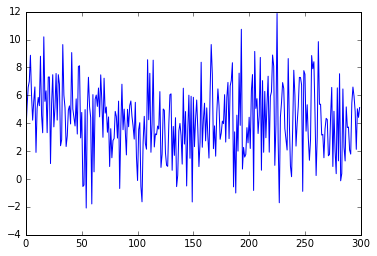

In [64]:
plt.plot(elbo_vals)

In [65]:
sess.run(gp.bin_mu)

array([ 0.4451491 , -0.69568869, -0.72090286,  0.45658261])

In [66]:
sess.run(gp.bin_sigma_l)

array([[ 0.63414324,  0.13271647,  0.14722346,  0.3062769 ],
       [ 0.15605637,  0.80628077, -0.02146601,  0.18284111],
       [ 0.20201319, -0.01336031,  0.77434395,  0.07954552],
       [ 0.30813232,  0.15338731,  0.08267271,  0.70281312]])

## Prediction

In [67]:
seq_lens_te = tf.constant(np.ones([x_te.shape[0]]) * max_len)

In [68]:
preds = gp.predict(x_te, seq_lens_te, sess)

_latent_vars_distribution/x_flat (?, 2) = sum_len x 2
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 2
cov_for_squared_dists/cov (2, 50, 5, 5) = [2, 50, 5, 5]
_Knns/K_nn (2, 50, 5, 5) = 2 x 50 x 5 x 5


In [69]:
np.sum(sess.run(y_te) == preds) / preds.size

0.68400000000000005

In [60]:
sess.close()